In [1]:
import h5py
import h5py
import numpy as np
from numpy import einsum
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

import configparser
import os
from os.path import join as pjoin
import json

import tensorflow as tf
tf.keras.backend.set_floatx('float32')
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
mse = MeanSquaredError()

import MD_AE_tools.models.models as mdl_bias
import MD_AE_tools.models.models_no_bias as mdl_nobias
from project_specific_utils.helpers import GetAttr
import MD_AE_tools.mode_decomposition as md
from project_specific_utils.data_and_train import TrainNN_from_config

2022-07-27 16:41:59.702345: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-07-27 16:41:59.702368: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# Linear MD-CNN-AE

In [3]:
parent_folder = '/home/ym917/Documents/Results/experiment_linear_standard_ae'
!ls -v $parent_folder

u_bias1-3473606  u_bias4-3473269  u_bias6-3473611  u_bias9-3473614
u_bias2-3473607  u_bias4-3473609  u_bias7-3473612  u_bias10-3473615
u_bias3-3473608  u_bias5-3473610  u_bias8-3473613


In [4]:
folder = 'u_bias1-3473606'
folder_path = pjoin(parent_folder,folder)
filename = pjoin(folder_path,'training_param.ini')
linear = TrainNN_from_config(filename)

filename = pjoin(folder_path,'results.h5')
with h5py.File(filename,'r') as hf:
    u_train = np.array(hf.get('u_train'))
    u_all = np.array(hf.get('u_all'))
    y_train = np.array(hf.get('y_train'))
    modes_train = np.array(hf.get('modes_train'))

In [ ]:
mdl = mdl_bias.MD_Autoencoder(linear.Nx,linear.Nu,linear.features_layers,linear.latent_dim,linear.filter_window, linear.act_fct, linear.BATCH_NORM, linear.drop_rate, linear.lmb, )
mdl.compile(optimizer=Adam(learning_rate=linear.learning_rate),loss='mse')
_ = mdl.predict(np.squeeze(u_train))

In [ ]:
filename = pjoin(folder_path,'md_ae_model.h5')
mdl.load_weights(filename)
print('MSE of traning is: ', mse(u_train,y_train).numpy())
# mdl.summary()

In [ ]:
decoders = mdl.get_decoders()

In [ ]:
b1 = decoders[0].predict(np.reshape(0,(1,1)))
wb1 = decoders[0].predict(np.reshape(1,(1,1)))
w1 = wb1-b1
b2 = decoders[1].predict(np.reshape(0,(1,1)))
wb2 = decoders[1].predict(np.reshape(1,(1,1)))
w2 = wb2-b2

# weights
fig, ax = plt.subplots(2,2,sharey='all')
fig.suptitle('decoder weights')
im1v = ax[0,0].imshow(w1[0,:,:,0],'jet')
div = make_axes_locatable(ax[0,0])
cax = div.append_axes('right',size='5%',pad='2%')
plt.colorbar(im1v,cax=cax)
im1w = ax[1,0].imshow(w1[0,:,:,1],'jet')
div = make_axes_locatable(ax[1,0])
cax = div.append_axes('right',size='5%',pad='2%')
plt.colorbar(im1w,cax=cax)
im2v = ax[0,1].imshow(w2[0,:,:,0],'jet')
div = make_axes_locatable(ax[0,1])
cax = div.append_axes('right',size='5%',pad='2%')
plt.colorbar(im2v,cax=cax)
im2w = ax[1,1].imshow(w2[0,:,:,1],'jet')
div = make_axes_locatable(ax[1,1])
cax = div.append_axes('right',size='5%',pad='2%')
plt.colorbar(im2w,cax=cax)
ax[0,0].set_title('1')
ax[0,1].set_title('2')
ax[0,0].set_ylabel('v')
ax[1,0].set_ylabel('w')

# bias
fig, ax = plt.subplots(2,2,sharey='all')
fig.suptitle('decoder bias')
im1v = ax[0,0].imshow(b1[0,:,:,0],'jet')
div = make_axes_locatable(ax[0,0])
cax = div.append_axes('right',size='5%',pad='2%')
plt.colorbar(im1v,cax=cax)
im1w = ax[1,0].imshow(b1[0,:,:,1],'jet')
div = make_axes_locatable(ax[1,0])
cax = div.append_axes('right',size='5%',pad='2%')
plt.colorbar(im1w,cax=cax)
im2v = ax[0,1].imshow(b2[0,:,:,0],'jet')
div = make_axes_locatable(ax[0,1])
cax = div.append_axes('right',size='5%',pad='2%')
plt.colorbar(im2v,cax=cax)
im2w = ax[1,1].imshow(b2[0,:,:,1],'jet')
div = make_axes_locatable(ax[1,1])
cax = div.append_axes('right',size='5%',pad='2%')
plt.colorbar(im2w,cax=cax)
ax[0,0].set_title('1')
ax[0,1].set_title('2')
ax[0,0].set_ylabel('v')
ax[1,0].set_ylabel('w')
plt.show()

In [5]:
x = einsum('t y z u -> y z t u',np.squeeze(u_train))
X = np.vstack((x[:,:,:,0],x[:,:,:,1]))
pod = md.POD(X)
Q_POD,lam_data = pod.get_modes()
Q_mean = pod.Q_mean
X_reconstructed = pod.reconstruct(2,shape=X.shape)
print('MSE reconstructed with 2 modes is: ', mse(X,X_reconstructed).numpy())

Calculating POD ...
Use classic POD, Nx <= Nt.
POD done.
MSE reconstructed with 2 modes is:  1.4704580307006836


/home/ym917/Documents/Codes/MD-CNN-AE/MD_AE_tools/mode_decomposition.py:189: RuntimeWarning: invalid value encountered in sqrt
  normQ = (Q_POD.T @ Q_POD*self.w).real**0.5
2022-07-27 16:42:41.733128: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-07-27 16:42:41.733162: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-07-27 16:42:41.733181: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ic-5rpzl43): /proc/driver/nvidia/version does not exist
2022-07-27 16:42:41.733561: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operatio

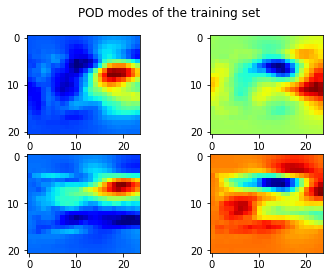

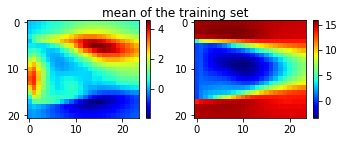

In [6]:
phi1 = Q_POD[:,0].reshape((42,24))
phi2 = Q_POD[:,1].reshape((42,24))
fig = plt.figure()
fig.suptitle('POD modes of the training set')
plt.subplot(221)
plt.imshow(phi1[:21,:],'jet')
plt.subplot(223)
plt.imshow(phi1[21:,:],'jet')
plt.subplot(222)
plt.imshow(phi2[:21,:],'jet')
plt.subplot(224)
plt.imshow(phi2[21:,:],'jet')


plt.figure(figsize=(5.5,1.8))
plt.suptitle('mean of the training set')
u_train_mean = np.mean(np.squeeze(u_train),axis=0)
plt.subplot(121)
plt.imshow(u_train_mean[:,:,0],'jet')
plt.colorbar()
plt.subplot(122)
plt.imshow(u_train_mean[:,:,1],'jet')
plt.colorbar()
plt.show()

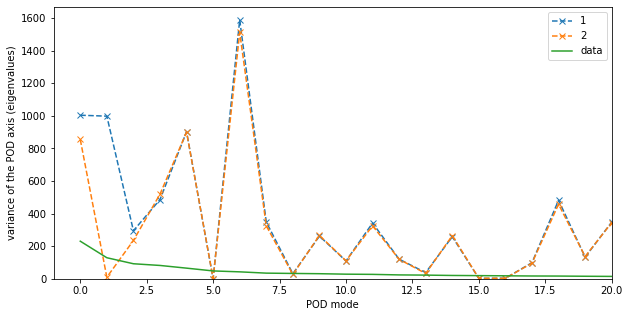

In [7]:
# reproject autoencoder modes onto data pod modes
x_train = einsum('k t y z u -> k y z t u',modes_train)
lam_modes = [] # how much of a POD is in an AE mode
for i in range(linear.latent_dim):
    X_train = np.vstack((x_train[i,:,:,:,0],x_train[i,:,:,:,1]))
    X_train = np.reshape(X_train,(-1,linear.Ntrain))
    A = einsum('x t, x m -> t m', X_train, Q_POD) # project
    lam_1 = einsum('t m -> m',A**2) / (linear.Ntrain - 1)
    lam_modes.append(lam_1)
lam_modes = np.array(lam_modes)
lam_modes_percent = lam_modes/lam_data

plt.figure(figsize=(10,5))
for i in range(linear.latent_dim):
    plt.plot(lam_modes[i,:],label=i+1,linestyle='--',marker='x')
plt.plot(lam_data,label='data')
plt.xlim([-1,20])
plt.ylim(bottom=0)
plt.ylabel('variance of the POD axis (eigenvalues)')
plt.xlabel('POD mode')
plt.legend()

plt.show()

# Nonlinear

In [ ]:
parent_folder = '/home/ym917/Documents/Results/experiment_nonlinear'
!ls -v $parent_folder
folder_list = ! ls -v $parent_folder | grep 2_mode*
# !tail -n 5 $parent_folder/*/log

In [ ]:
print(folder_list)

In [ ]:
folder = '2_mode10-4022815'
folder_path = pjoin(parent_folder,folder)
filename = pjoin(folder_path,'training_param.ini')
nonlinear = TrainNN_from_config(filename)

filename = pjoin(folder_path,'results.h5')
with h5py.File(filename,'r') as hf:
    u_train = np.array(hf.get('u_train'))
    u_all = np.array(hf.get('u_all'))
    y_train = np.array(hf.get('y_train'))
    modes_train = np.array(hf.get('modes_train'))

print('MSE of traning is: ', mse(u_train,y_train).numpy())

In [ ]:
## data 
x = einsum('t y z u -> y z t u',np.squeeze(u_train))
X = np.vstack((x[:,:,:,0],x[:,:,:,1]))
pod = md.POD(X)
Q_POD,lam_data = pod.get_modes()
Q_mean = pod.Q_mean
X_reconstructed = pod.reconstruct(2,shape=X.shape)
print('MSE reconstructed with 2 modes is: ', mse(X,X_reconstructed).numpy())

phi1 = Q_POD[:,0].reshape((42,24))
phi2 = Q_POD[:,1].reshape((42,24))
fig = plt.figure()
fig.suptitle('POD modes of the training set')
plt.subplot(221)
plt.imshow(phi1[:21,:],'jet')
plt.colorbar()
plt.subplot(223)
plt.imshow(phi1[21:,:],'jet')
plt.colorbar()
plt.subplot(222)
plt.imshow(phi2[:21,:],'jet')
plt.colorbar()
plt.subplot(224)
plt.imshow(phi2[21:,:],'jet')
plt.colorbar()
plt.show()

In [ ]:
# reproject autoencoder modes onto data pod modes
x_train = einsum('k t y z u -> k y z t u',modes_train)
lam_modes = [] # how much of a POD is in an AE mode
for i in range(nonlinear.latent_dim):
    X_train = np.vstack((x_train[i,:,:,:,0],x_train[i,:,:,:,1]))
    X_train = np.reshape(X_train,(-1,nonlinear.Ntrain))
    A = einsum('x t, x m -> t m', X_train, Q_POD) # project
    lam_1 = einsum('t m -> m',A**2) / (nonlinear.Ntrain - 1)
    lam_modes.append(lam_1)
lam_modes = np.array(lam_modes)
lam_modes_percent = lam_modes/lam_data

In [ ]:
plt.figure(figsize=(10,5))
for i in range(nonlinear.latent_dim):
    plt.plot(lam_modes[i,:],label=i+1,linestyle='--',marker='x')
plt.plot(lam_data,label='data')
plt.xlim([-1,20])
plt.ylim(bottom=0)
plt.ylabel('variance of the POD axis (eigenvalues)')
plt.xlabel('POD mode')
plt.legend()

plt.figure(figsize=(10,5))
for i in range(nonlinear.latent_dim):
    plt.plot(lam_modes_percent[i,:],label=i+1,linestyle='--',marker='x')
plt.xlim([-1,20])
plt.ylim([0,1])
plt.legend()
plt.xlabel('POD mode')
plt.title('precentage of POD modes captured')

plt.show()

In [ ]:
## save reporjected results to csv

# csv1 = pjoin(parent_folder,'grouping_modes_1.csv')
# csv2 = pjoin(parent_folder,'grouping_modes_2.csv')
# with open(csv1,'a') as f1, open(csv2,'a') as f2:
#     if lam_modes[0,0] > lam_modes[1,0]:
#         np.savetxt(f1,lam_modes_percent[[0],:],delimiter=',')
#         np.savetxt(f2,lam_modes_percent[[1],:],delimiter=',')
#     elif lam_modes[1,0] > lam_modes[0,0]:
#         np.savetxt(f1,lam_modes_percent[[1],:],delimiter=',')
#         np.savetxt(f2,lam_modes_percent[[0],:],delimiter=',')

### From CSV, calculate average

In [ ]:
## load reprojected results from csv

csv1 = pjoin(parent_folder,'grouping_modes_1.csv')
csv2 = pjoin(parent_folder,'grouping_modes_2.csv')

lam_modes_total1 = np.loadtxt(csv1, delimiter=',')
lam_modes_total2 = np.loadtxt(csv2, delimiter=',')

In [ ]:
l1_mean = np.mean(lam_modes_total1,axis=0)
l1_std = np.std(lam_modes_total1,axis=0)
l2_mean = np.mean(lam_modes_total2,axis=0)
l2_std = np.std(lam_modes_total2,axis=0)

fig, (ax1,ax2) = plt.subplots(nrows=2,ncols=1,sharex=True,sharey=True, figsize=(6,6))
fig.suptitle('Re-projecting autoencoder mode to data POD mode (onto eigenvector)')
ax1.set_title('autoencoder mode primarily made up of POD mode 1')
ax1.errorbar(np.arange(1,len(l1_mean+1)+1),l1_mean*100, yerr=l1_std*100, fmt='s', capsize=2)
ax1.set_xticks(np.arange(1,len(l1_mean+1)+1))
ax1.set_xlim([0.5,10.5])
ax1.set_ylim([0,100])
ax2.set_title('the other autoencoder mode')
ax2.errorbar(np.arange(1,len(l1_mean+1)+1),l2_mean*100, yerr=l2_std*100, fmt='s', capsize=2)
ax2.set_ylabel("% of data POD mode")
ax2.set_xlabel('POD mode of data')
plt.show()